# Building a machine learning model to predict how Corporate Bonds' yields Index will react to variation of interest rates

### For those of you who are not familiar with this index, I will copy the description provided by Nasdaq:

##### "The Index is based on the Merrill Lynch Bond Indices as published on www.cbonds.info. Augmented by data from other data sources."

## Libraries

We are importing:

In [322]:
# Pandas to handle dataframes 

import pandas as pd

# Matplotilib for data visualization

import matplotlib.pyplot as plt

# Scikit-Learn and its Random Forest Regressor to build the predictive model 

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor 

print("Libraries succesfully imported")

Libraries succesfully imported


## Data Collecting 

#### Gathering Consumer Price Index data in the US since 1913 

In [326]:
cpi = pd.read_csv(r"inflation.csv")[['Year', 'Dec']].rename(columns={'Dec':'CPI'}).dropna()

In [327]:
cpi['Year'] = cpi['Year'].apply(lambda x: int(x))
cpi.tail()

,Year,CPI
104,2017,246.524
105,2018,251.233
106,2019,256.974
107,2020,260.474
108,2021,278.802


We can compute the % change between each year to obtain inflation rate

In [330]:
cpi['Inflation Rate'] = cpi['CPI'].pct_change()

In [331]:
inflation_rate = cpi[['Year', 'Inflation Rate']].dropna()

inflation_rate.tail()

,Year,Inflation Rate
104,2017,0.021091
105,2018,0.019102
106,2019,0.022851
107,2020,0.013620
108,2021,0.070364


Filtering dataset for the years we are interested in:

In [332]:
inflation_rate = inflation_rate[(inflation_rate['Year'] > 2002) & (inflation_rate['Year'] < 2022)].reset_index(drop=True)

In [333]:
inflation_rate.head()

,Year,Inflation Rate
0,2003,0.018795
1,2004,0.032556
2,2005,0.034157
3,2006,0.025407
4,2007,0.040813


#### Gathering US Treasury Real Yields data

In [334]:
treasury_yields = pd.read_csv(r"USTREASURY-REALYIELD.csv")

treasury_yields.head()

,Date,5 YR,7 YR,10 YR,20 YR,30 YR
0,2023-07-21,1.86,1.64,1.49,1.51,1.62
1,2023-07-20,1.87,1.65,1.50,1.52,1.62
2,2023-07-19,1.85,1.65,1.53,1.53,1.61
3,2023-07-18,1.87,1.69,1.57,1.58,1.66
4,2023-07-17,1.86,1.68,1.56,1.58,1.67


We only need the year, we can obtain it while manipulating the string in the "Date" column.

In [335]:
treasury_yields['Year'] = treasury_yields['Date'].apply(lambda x: int(x.split("-")[0]))

In [336]:
treasury_yields.head()

,Date,5 YR,7 YR,10 YR,20 YR,30 YR,Year
0,2023-07-21,1.86,1.64,1.49,1.51,1.62,2023
1,2023-07-20,1.87,1.65,1.50,1.52,1.62,2023
2,2023-07-19,1.85,1.65,1.53,1.53,1.61,2023
3,2023-07-18,1.87,1.69,1.57,1.58,1.66,2023
4,2023-07-17,1.86,1.68,1.56,1.58,1.67,2023


Now we can groupby the data for year to obtain the average return for US Treasuries in a given year, also we are filtering for the right years

In [337]:
treasury_yields = treasury_yields.groupby('Year', as_index=False).mean()

treasury_yields = treasury_yields[(treasury_yields['Year'] > 2002) & (treasury_yields['Year'] < 2022)].reset_index(drop=True)

treasury_yields.head()

,Year,5 YR,7 YR,10 YR,20 YR,30 YR
0,2003,1.268120,1.731600,2.058520,NaN,NaN
1,2004,1.041480,1.445800,1.831080,2.137156,NaN
2,2005,1.495760,1.633520,1.814120,1.967360,NaN
3,2006,2.278760,2.293800,2.311280,2.308880,NaN
4,2007,2.145777,2.247291,2.286614,2.358685,NaN


As we can see, for some years "20 YR" and "30 YR" data is missing, 

There is a reason behind of course:

Until 2001, the United States Treasury regularly issued and sold 30-year Treasuries. 
However, in February 2002, the Bush administration announced a temporary suspension of regular auctions for 30-year Treasury Bonds. 
Subsequently, the U.S. Treasury reintroduced the 30-year Treasury Bonds in 2006 due to increasing interest rates and the need to extend the government's average debt maturity.
From that point onward, 30-year Treasury Bonds have been regularly issued, and data on their yields became available again.

In [338]:
treasury_yields.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    19 non-null     int64  
 1   5 YR    19 non-null     float64
 2   7 YR    19 non-null     float64
 3   10 YR   19 non-null     float64
 4   20 YR   18 non-null     float64
 5   30 YR   12 non-null     float64
dtypes: float64(5), int64(1)
memory usage: 1.0 KB


We should delete this data, but we cannot build a machine learning model with missing data, so for the sake of the project, we are replacing missing values with 0, since at the time there were no 30Y treasury bonds

In [339]:
treasury_yields = treasury_yields.fillna(0)
treasury_yields.head()

,Year,5 YR,7 YR,10 YR,20 YR,30 YR
0,2003,1.268120,1.731600,2.058520,0.000000,0.0
1,2004,1.041480,1.445800,1.831080,2.137156,0.0
2,2005,1.495760,1.633520,1.814120,1.967360,0.0
3,2006,2.278760,2.293800,2.311280,2.308880,0.0
4,2007,2.145777,2.247291,2.286614,2.358685,0.0


### Now we are gathering data for US Bill Notes' yields

In [269]:
treasury_billrates = pd.read_csv(r"USTREASURY-BILLRATES.csv")

treasury_billrates.head()

,Date,4 Wk Bank Discount Rate,4 Wk Coupon Equiv,8 Wk Bank Discount Rate,8 Wk Coupon Equiv,13 Wk Bank Discount Rate,13 Wk Coupon Equiv,26 Wk Bank Discount Rate,26 Wk Coupon Equiv,52 Wk Bank Discount Rate,52 Wk Coupon Equiv
0,2023-07-21,5.26,5.37,5.27,5.40,5.27,5.43,5.27,5.50,5.07,5.36
1,2023-07-20,5.27,5.38,5.27,5.40,5.26,5.42,5.26,5.49,5.07,5.36
2,2023-07-19,5.17,5.28,5.25,5.38,5.26,5.42,5.25,5.48,5.04,5.32
3,2023-07-18,5.18,5.29,5.24,5.37,5.25,5.41,5.25,5.48,5.04,5.33
4,2023-07-17,5.19,5.30,5.24,5.37,5.26,5.42,5.26,5.49,5.05,5.34


In [270]:
treasury_billrates['Year'] = treasury_billrates['Date'].apply(lambda x: int(x.split("-")[0]))
treasury_billrates = treasury_billrates.groupby('Year', as_index=False).mean().drop(["8 Wk Bank Discount Rate", "8 Wk Coupon Equiv"], axis=1)

treasury_billrates.head()

,Year,4 Wk Bank Discount Rate,4 Wk Coupon Equiv,13 Wk Bank Discount Rate,13 Wk Coupon Equiv,26 Wk Bank Discount Rate,26 Wk Coupon Equiv,52 Wk Bank Discount Rate,52 Wk Coupon Equiv
0,2002,1.60184,1.62724,1.60532,1.63368,1.67592,1.71388,1.666,1.692
1,2003,1.00016,1.01852,1.00836,1.02828,1.05332,1.07468,NaN,NaN
2,2004,1.24412,1.26212,1.37464,1.40024,1.57764,1.61428,NaN,NaN
3,2005,2.93952,2.98616,3.14916,3.21924,3.39428,3.50248,NaN,NaN
4,2006,4.66608,4.74692,4.73000,4.85260,4.80720,4.99504,NaN,NaN


Also here there are a few missing values, we will replace them with 0, just as we did before

In [271]:
treasury_billrates = treasury_billrates.fillna(0)
treasury_billrates.head()

,Year,4 Wk Bank Discount Rate,4 Wk Coupon Equiv,13 Wk Bank Discount Rate,13 Wk Coupon Equiv,26 Wk Bank Discount Rate,26 Wk Coupon Equiv,52 Wk Bank Discount Rate,52 Wk Coupon Equiv
0,2002,1.60184,1.62724,1.60532,1.63368,1.67592,1.71388,1.666,1.692
1,2003,1.00016,1.01852,1.00836,1.02828,1.05332,1.07468,0.000,0.000
2,2004,1.24412,1.26212,1.37464,1.40024,1.57764,1.61428,0.000,0.000
3,2005,2.93952,2.98616,3.14916,3.21924,3.39428,3.50248,0.000,0.000
4,2006,4.66608,4.74692,4.73000,4.85260,4.80720,4.99504,0.000,0.000


### The data we have been importing so far will be the data we will use to predict our Y: Corporate Bonds Yields

The final step is now importing our Y

In [276]:
corporate_bonds_yields = pd.read_csv(r"corporate_bonds_yields.csv")
corporate_bonds_yields.head()

,DATE,BAMLC0A0CMEY
0,2023-07-20,5.51
1,2023-07-19,5.42
2,2023-07-18,5.47
3,2023-07-17,5.49
4,2023-07-14,5.49


In [277]:
corporate_bonds_yields['Year'] = corporate_bonds_yields['DATE'].apply(lambda x: int(x.split("-")[0]))
corporate_bonds_yields = corporate_bonds_yields.groupby('Year', as_index=False).mean()[['Year','BAMLC0A0CMEY']]
corporate_bonds_yields = corporate_bonds_yields[corporate_bonds_yields["Year"] > 2002].rename(columns={"BAMLC0A0CMEY":"US Corporate Bonds Yield"})

In [278]:
corporate_bonds_yields.head(10)

,Year,US Corporate Bonds Yield
7,2003,4.605939
8,2004,4.598061
9,2005,5.090920
10,2006,5.753654
11,2007,5.801269
12,2008,6.774542
13,2009,6.269084
14,2010,4.211217
15,2011,3.882222
16,2012,3.202462


### Now we are ready to build our final dataframe which will be useful to build our machine learning model

In [279]:
df = corporate_bonds_yields.merge(inflation_rate, on="Year")
df = df.merge(treasury_yields, on='Year')
df = df.merge(treasury_billrates, on='Year')

In [280]:
df.set_index("Year", inplace=True)

In [388]:
df.tail(20)

,US Corporate Bonds Yield,Inflation Rate,5 YR,7 YR,10 YR,20 YR,30 YR,4 Wk Bank Discount Rate,4 Wk Coupon Equiv,13 Wk Bank Discount Rate,13 Wk Coupon Equiv,26 Wk Bank Discount Rate,26 Wk Coupon Equiv,52 Wk Bank Discount Rate,52 Wk Coupon Equiv
Year,,,,,,,,,,,,,,,
2003,4.605939,0.018795,1.268120,1.731600,2.058520,0.000000,0.000000,1.000160,1.018520,1.008360,1.028280,1.053320,1.074680,0.000000,0.000000
2004,4.598061,0.032556,1.041480,1.445800,1.831080,2.137156,0.000000,1.244120,1.262120,1.374640,1.400240,1.577640,1.614280,0.000000,0.000000
2005,5.090920,0.034157,1.495760,1.633520,1.814120,1.967360,0.000000,2.939520,2.986160,3.149160,3.219240,3.394280,3.502480,0.000000,0.000000
2006,5.753654,0.025407,2.278760,2.293800,2.311280,2.308880,0.000000,4.666080,4.746920,4.730000,4.852600,4.807200,4.995040,0.000000,0.000000
2007,5.801269,0.040813,2.145777,2.247291,2.286614,2.358685,0.000000,4.320159,4.403625,4.361952,4.481315,4.438685,4.615896,0.000000,0.000000
2008,6.774542,0.000914,1.303028,1.628446,1.770717,2.180159,0.000000,1.266972,1.287251,1.371315,1.397331,1.621195,1.660239,1.630616,1.677192
2009,6.269084,0.027213,1.058520,1.315080,1.658360,2.214120,0.000000,0.094578,0.094578,0.150520,0.150520,0.279200,0.281880,0.451160,0.460400
2010,4.211217,0.014957,0.258287,0.679442,1.151394,1.731275,1.817431,0.113825,0.113825,0.138446,0.138446,0.196295,0.196295,0.301912,0.305777
2011,3.882222,0.029624,-0.409360,0.090840,0.549760,1.189120,1.465960,0.039280,0.039280,0.052840,0.052840,0.095680,0.095680,0.170200,0.170480


## Let's visualize our data

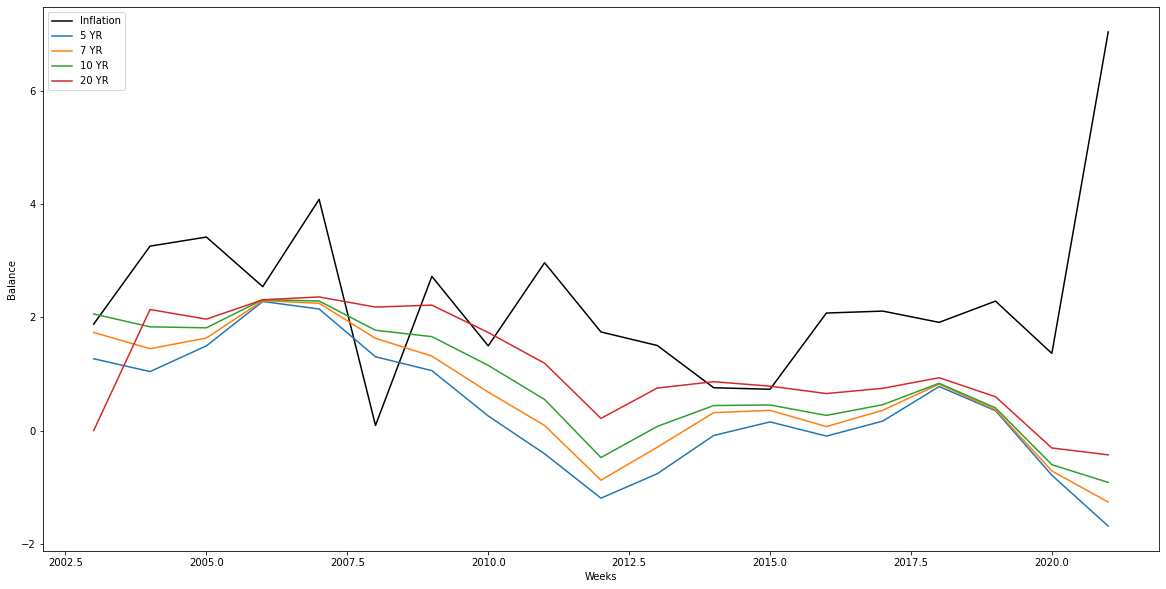

In [398]:
plt.figure(figsize=(20, 10))

plt.plot(df.index, df['Inflation Rate']*100, color="Black", label="Inflation", )

for column in df[["5 YR", "7 YR", "10 YR", "20 YR"]]:
    plt.plot(df.index, df[column], label=column)

plt.xlabel("Weeks")
plt.ylabel("Balance")
plt.legend(loc="upper left")
plt.show()

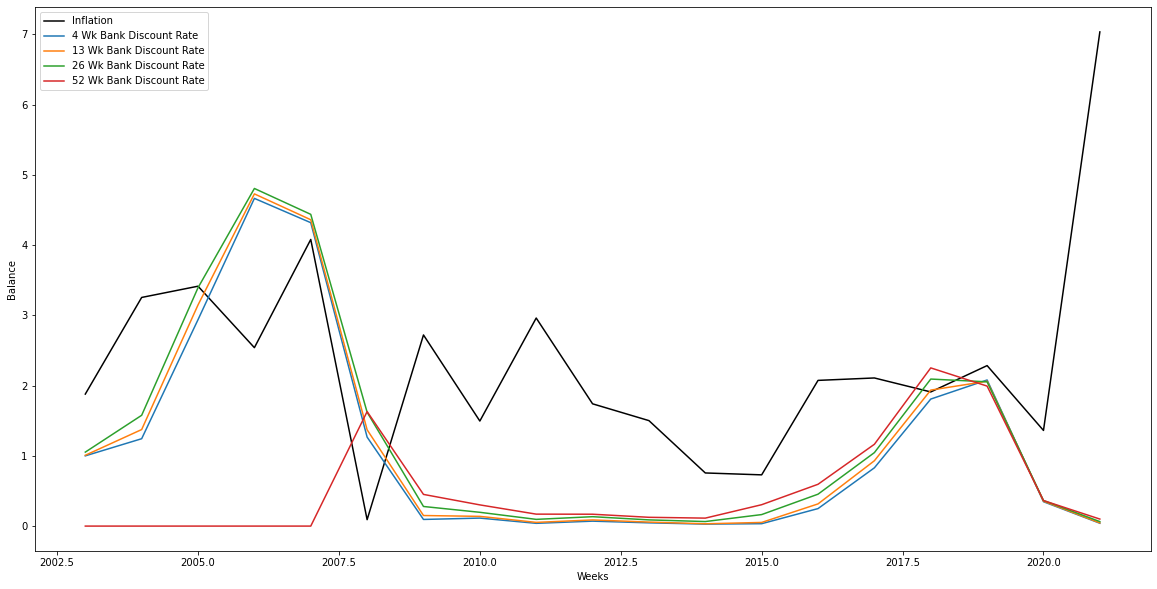

In [405]:
plt.figure(figsize=(20, 10))

plt.plot(df.index, df['Inflation Rate']*100, color="Black", label="Inflation", )

for column in df[["4 Wk Bank Discount Rate", "13 Wk Bank Discount Rate", "26 Wk Bank Discount Rate", "52 Wk Bank Discount Rate"]]:
    plt.plot(df.index, df[column], label=column)

plt.xlabel("Weeks")
plt.ylabel("Balance")
plt.legend(loc="upper left")
plt.show()

## Machine Learning Model

Time to define our x and y

In [359]:
# x

x = df.drop("US Corporate Bonds Yield", axis=1)

x.head()

,Inflation Rate,5 YR,7 YR,10 YR,20 YR,30 YR,4 Wk Bank Discount Rate,4 Wk Coupon Equiv,13 Wk Bank Discount Rate,13 Wk Coupon Equiv,26 Wk Bank Discount Rate,26 Wk Coupon Equiv,52 Wk Bank Discount Rate,52 Wk Coupon Equiv
Year,,,,,,,,,,,,,,
2003,0.018795,1.268120,1.731600,2.058520,0.000000,0.0,1.000160,1.018520,1.008360,1.028280,1.053320,1.074680,0.0,0.0
2004,0.032556,1.041480,1.445800,1.831080,2.137156,0.0,1.244120,1.262120,1.374640,1.400240,1.577640,1.614280,0.0,0.0
2005,0.034157,1.495760,1.633520,1.814120,1.967360,0.0,2.939520,2.986160,3.149160,3.219240,3.394280,3.502480,0.0,0.0
2006,0.025407,2.278760,2.293800,2.311280,2.308880,0.0,4.666080,4.746920,4.730000,4.852600,4.807200,4.995040,0.0,0.0
2007,0.040813,2.145777,2.247291,2.286614,2.358685,0.0,4.320159,4.403625,4.361952,4.481315,4.438685,4.615896,0.0,0.0


In [360]:
# y

y = df['US Corporate Bonds Yield']

y.head()

Year
2003    4.605939
2004    4.598061
2005    5.090920
2006    5.753654
2007    5.801269
Name: US Corporate Bonds Yield, dtype: float64

We are now going to build a model

## Random Forest Regressor

We are now going to train the model 

In [361]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1)

In [362]:
rfr = RandomForestRegressor()

In [363]:
rfr.fit(x_train,y_train)

RandomForestRegressor()

## Let's now make our prediction for 2023

We are now going to predict US Corporate Bonds' Yield Index for current year (2023). 

We, of course, already know the value of 2023 Corporate Bonds' Yield Index: we can find it on Nasdaq.

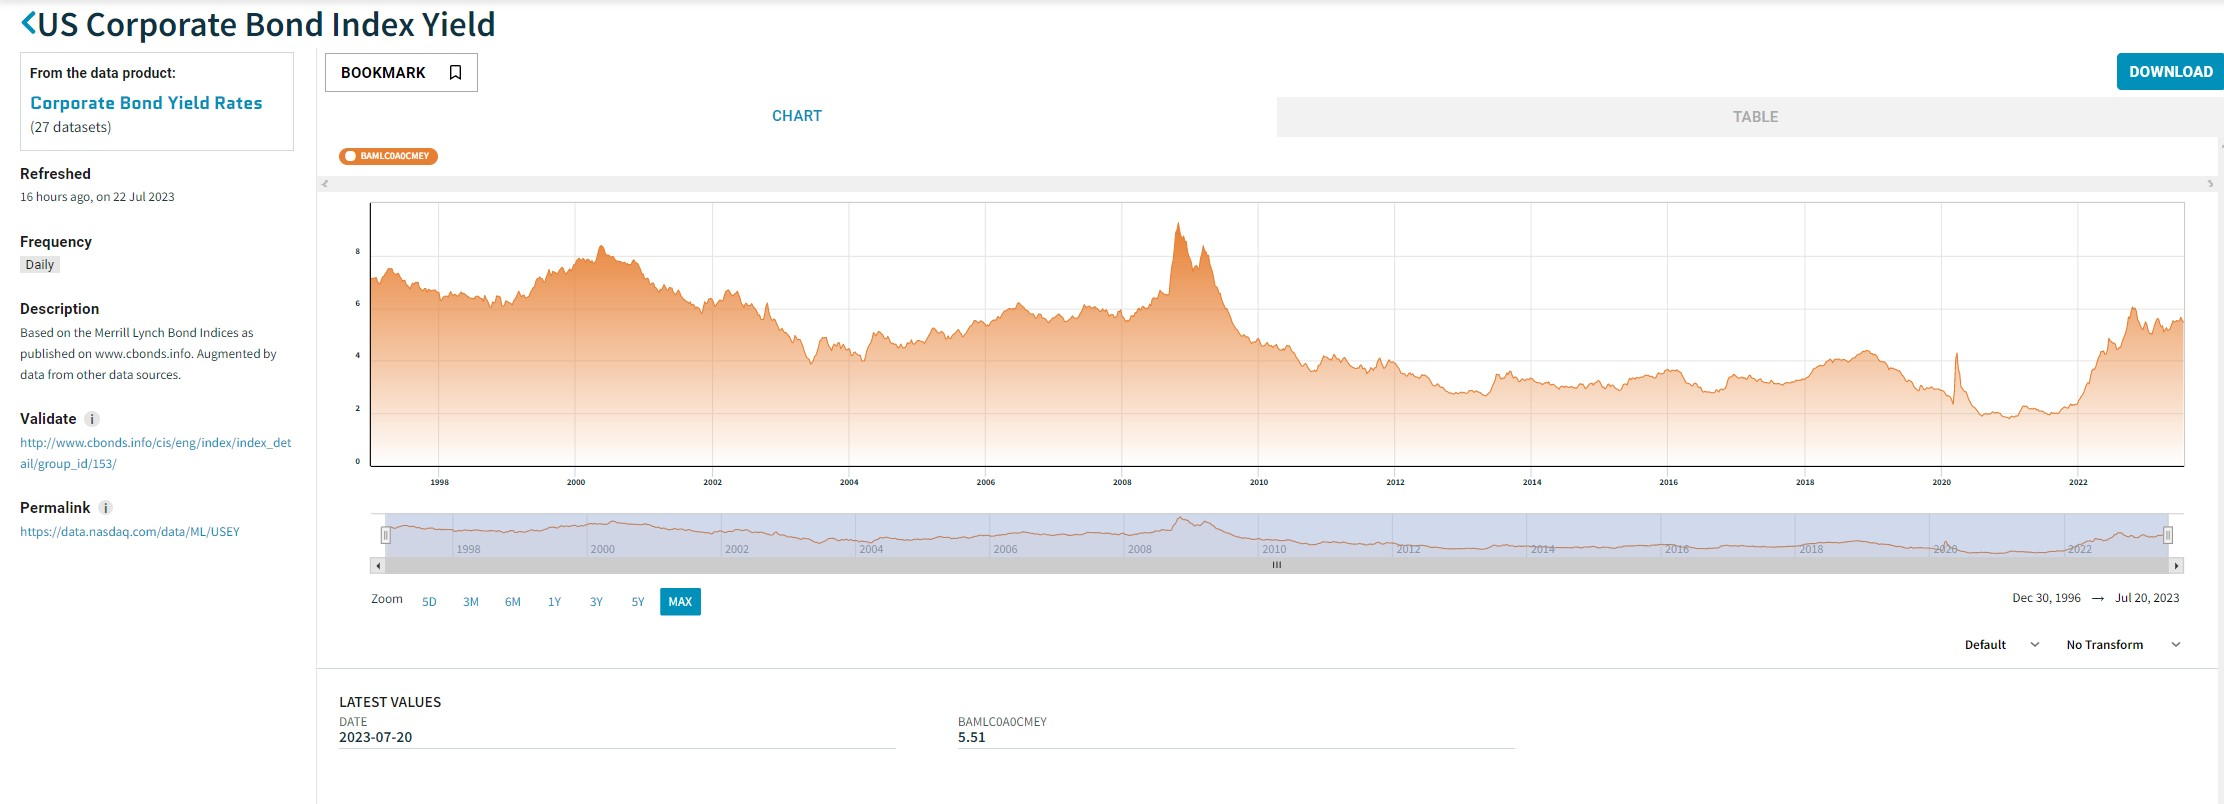

## The value we are trying to predict is: 5.51

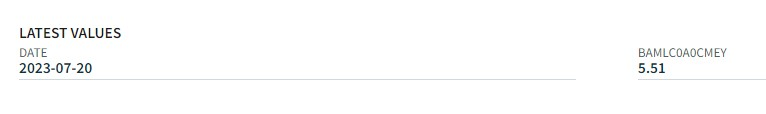

Let's see how the model will perform.

We will give the model the X for the current year: 

* Inflation
* Yields for US30Y, US20Y, US10Y, US7YR, US5YR treasury rates
* Yields for 4 Weeks, 8 Weeks, 13 Weeks, 26 Weeks and 52 Weeks Bank Discount

And the model will predict US Corporate Bonds' Yield Index for 2023

In [364]:
bill_notes_df_2023 = pd.read_csv("daily-treasury-rates.csv")

# And also data about: 

# Inflation

inflation_rate_2023_july = 0.03

# Treasury Yields

US30Y = 3.901
US20Y = 4.104
US10Y = 3.841
US7YR = 3.971
US5YR = 4.095


bill_notes_df_2023.head()

,Date,4 WEEKS BANK DISCOUNT,4 WEEKS COUPON EQUIVALENT,8 WEEKS BANK DISCOUNT,8 WEEKS COUPON EQUIVALENT,13 WEEKS BANK DISCOUNT,13 WEEKS COUPON EQUIVALENT,17 WEEKS BANK DISCOUNT,17 WEEKS COUPON EQUIVALENT,26 WEEKS BANK DISCOUNT,26 WEEKS COUPON EQUIVALENT,52 WEEKS BANK DISCOUNT,52 WEEKS COUPON EQUIVALENT
0,07/21/2023,5.26,5.37,5.27,5.40,5.27,5.43,5.27,5.45,5.27,5.50,5.07,5.36
1,07/20/2023,5.27,5.38,5.27,5.40,5.26,5.42,5.28,5.46,5.26,5.49,5.07,5.36
2,07/19/2023,5.17,5.28,5.25,5.38,5.26,5.42,5.27,5.45,5.25,5.48,5.04,5.32
3,07/18/2023,5.18,5.29,5.24,5.37,5.25,5.41,5.26,5.44,5.25,5.48,5.04,5.33
4,07/17/2023,5.19,5.30,5.24,5.37,5.26,5.42,5.27,5.45,5.26,5.49,5.05,5.34


In [365]:
bill_notes_df_2023_2 = bill_notes_df_2023.iloc[len(bill_notes_df_2023)-1]

In [366]:
bill_notes_df_2023_2.tail(12)

4 WEEKS BANK DISCOUNT         3.96
4 WEEKS COUPON EQUIVALENT     4.03
8 WEEKS BANK DISCOUNT         4.29
8 WEEKS COUPON EQUIVALENT     4.38
13 WEEKS BANK DISCOUNT         4.4
13 WEEKS COUPON EQUIVALENT    4.51
17 WEEKS BANK DISCOUNT        4.57
17 WEEKS COUPON EQUIVALENT     4.7
26 WEEKS BANK DISCOUNT        4.63
26 WEEKS COUPON EQUIVALENT    4.81
52 WEEKS BANK DISCOUNT         4.5
52 WEEKS COUPON EQUIVALENT    4.72
Name: 138, dtype: object

In [367]:
x_2023 = {"Inflation Rate": 0.03, '5 YR': US5YR, "7 YR": US7YR, "10 YR": US10Y, "20 YR": US20Y, "30 YR": US30Y, "4 Wk Bank Discount Rate":new_prediction_df2[1], "4 Wk Coupon Equiv":new_prediction_df2[2],"13 Wk Bank Discount Rate":new_prediction_df2[5], "13 Wk Coupon Equiv": new_prediction_df2[6], "26 Wk Bank Discount Rate":new_prediction_df2[9],"26 Wk Coupon Equiv":new_prediction_df2[10],"52 Wk Bank Discount Rate":new_prediction_df2[11], "52 Wk Coupon Equiv":new_prediction_df2[12]}

In [378]:
x_2023 = x.append(x_2023, ignore_index=True)

x_2023.tail()

,Inflation Rate,5 YR,7 YR,10 YR,20 YR,30 YR,4 Wk Bank Discount Rate,4 Wk Coupon Equiv,13 Wk Bank Discount Rate,13 Wk Coupon Equiv,26 Wk Bank Discount Rate,26 Wk Coupon Equiv,52 Wk Bank Discount Rate,52 Wk Coupon Equiv
53,0.019102,0.777711,0.820241,0.834618,0.933173,1.008313,1.808675,1.836265,1.936305,1.973655,2.093494,2.145341,2.252410,2.323333
54,0.022851,0.352200,0.368360,0.400840,0.597720,0.780080,2.080320,2.117680,2.062480,2.106200,2.054080,2.110320,1.993320,2.055480
55,0.013620,-0.787450,-0.712590,-0.601673,-0.306653,-0.105060,0.347211,0.352351,0.354741,0.359841,0.364343,0.370916,0.363386,0.370080
56,0.070364,-1.685339,-1.261235,-0.914781,-0.428008,-0.197331,0.040677,0.040677,0.045020,0.045020,0.063944,0.063944,0.100040,0.100199
57,0.030000,4.095000,3.971000,3.841000,4.104000,3.901000,3.960000,4.030000,4.400000,4.510000,4.630000,4.810000,4.500000,4.720000


In [381]:
current_x = x_2023.tail(1).reset_index(drop=True)

In [382]:
current_x.head()

,Inflation Rate,5 YR,7 YR,10 YR,20 YR,30 YR,4 Wk Bank Discount Rate,4 Wk Coupon Equiv,13 Wk Bank Discount Rate,13 Wk Coupon Equiv,26 Wk Bank Discount Rate,26 Wk Coupon Equiv,52 Wk Bank Discount Rate,52 Wk Coupon Equiv
0,0.03,4.095,3.971,3.841,4.104,3.901,3.96,4.03,4.4,4.51,4.63,4.81,4.5,4.72


In [383]:
new_prediction = rfr.predict(current_x)

In [387]:
print("The model predicted: ", round(new_prediction[0],3))

The model predicted:  5.867


## The model predict is: 5.867

### Not a bad result! The model is a few points from the real value 0.35 from its current value, our machine learning model performed very well.